# Data preparation

In this assignment, we'll use the dataset and data preparation used in [Hands-on Machine Learning with Scikit-Learn, Keras and TensorFlow](https://github.com/ageron/handson-ml3/blob/main/15_processing_sequences_using_rnns_and_cnns.ipynb) book.

In [ ]:
!wget https://github.com/ageron/data/raw/main/ridership.tgz

--2025-04-23 22:53:57--  https://github.com/ageron/data/raw/main/ridership.tgz
Resolving github.com (github.com)... 20.27.177.113
Connecting to github.com (github.com)|20.27.177.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/ageron/data/main/ridership.tgz [following]
--2025-04-23 22:53:58--  https://raw.githubusercontent.com/ageron/data/main/ridership.tgz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 108512 (106K) [application/octet-stream]
Saving to: ‘ridership.tgz.1’

ridership.tgz.1     100%[===================>] 105.97K  --.-KB/s    in 0.09s   

2025-04-23 22:53:58 (1.10 MB/s) - ‘ridership.tgz.1’ saved [108512/108512]



In [ ]:
!tar -xf ridership.tgz

In [ ]:
import pandas as pd

df = pd.read_csv("ridership/CTA_-_Ridership_-_Daily_Boarding_Totals.csv", parse_dates=["service_date"])
df.columns = ["date", "day_type", "bus", "rail", "total"]                       # shorter names

df = df.sort_values("date").set_index("date")
df = df.drop("total", axis=1)                     # no need for total, it's just bus + rail
df = df.drop_duplicates()                         # remove duplicated months (2011-10 and 2014-07)

In [ ]:
df.head()

,day_type,bus,rail
date,,,
2001-01-01,U,297192,126455
2001-01-02,W,780827,501952
2001-01-03,W,824923,536432
2001-01-04,W,870021,550011
2001-01-05,W,890426,557917


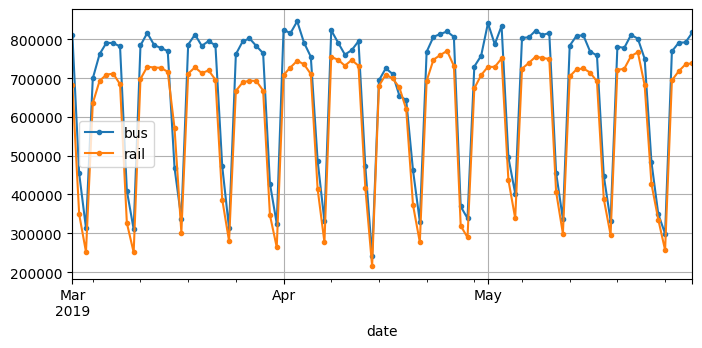

In [ ]:
import matplotlib.pyplot as plt
df["2019-03":"2019-05"].plot(grid=True, marker=".", figsize=(8, 3.5))
plt.show()

In [ ]:
rail_train = df["rail"]["2016-01":"2018-12"] / 1e6
rail_valid = df["rail"]["2019-01":"2019-05"] / 1e6
rail_test = df["rail"]["2019-06":] / 1e6

In [ ]:
rail_train

,rail
date,
2016-01-01,0.319835
2016-01-02,0.365509
2016-01-03,0.287661
2016-01-04,0.703185
2016-01-05,0.727716
...,...
2018-12-27,0.453029
2018-12-28,0.493961
2018-12-29,0.307105


# Exercise

You're task to model the rail's sequences. The data is split into train, validation and test. Each example consists of 57 consective time steps where the first 56 steps are the input and the last time step is the output. For each model you should report the MSE, RMSE and MAE.

The required models:
* MLP
* RNN
* GRU
* Transformer encoder


## Deliverables
* The code.
* Table summarizing the hyperparameters and the result.
* A brief write-up describing the experiment, results, and analysis.

## **Imports**

In [ ]:
import math
import torch
import numpy as np
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
criterion = torch.nn.MSELoss()

## **Data Preparation**

In [ ]:
# Prepare the Training data for the Models
rail_train_cpy = rail_train.copy().to_frame()
rail_train_cpy = rail_train_cpy.rename(columns={"rail": "step_1"})

for step in range(1, 57):

    if step < 56:
        rail_train_cpy[f'step_{step+1}'] = rail_train_cpy['step_1'].shift(step)

    elif step == 56:
        rail_train_cpy[f'target'] = rail_train_cpy['step_1'].shift(step)

In [ ]:
rail_train_cpy

,step_1,step_2,step_3,step_4,step_5,step_6,step_7,step_8,step_9,step_10,...,step_48,step_49,step_50,step_51,step_52,step_53,step_54,step_55,step_56,target
date,,,,,,,,,,,,,,,,,,,,,
2016-01-01,0.319835,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-01-02,0.365509,0.319835,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-01-03,0.287661,0.365509,0.319835,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-01-04,0.703185,0.287661,0.365509,0.319835,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-01-05,0.727716,0.703185,0.287661,0.365509,0.319835,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-27,0.453029,0.411993,0.127994,0.279324,0.260130,0.339426,0.633479,0.682043,0.700814,0.701867,...,0.385710,0.751427,0.797333,0.783160,0.764653,0.770186,0.291311,0.428523,0.754310,0.798312
2018-12-28,0.493961,0.453029,0.411993,0.127994,0.279324,0.260130,0.339426,0.633479,0.682043,0.700814,...,0.304712,0.385710,0.751427,0.797333,0.783160,0.764653,0.770186,0.291311,0.428523,0.754310
2018-12-29,0.307105,0.493961,0.453029,0.411993,0.127994,0.279324,0.260130,0.339426,0.633479,0.682043,...,0.652215,0.304712,0.385710,0.751427,0.797333,0.783160,0.764653,0.770186,0.291311,0.428523


In [ ]:
# drop nan
rail_train_cpy.dropna(inplace= True)
rail_train_cpy

,step_1,step_2,step_3,step_4,step_5,step_6,step_7,step_8,step_9,step_10,...,step_48,step_49,step_50,step_51,step_52,step_53,step_54,step_55,step_56,target
date,,,,,,,,,,,,,,,,,,,,,
2016-02-26,0.749991,0.762858,0.725712,0.765309,0.745072,0.311190,0.464149,0.761996,0.773317,0.766940,...,0.263073,0.391597,0.732495,0.736809,0.733167,0.727716,0.703185,0.287661,0.365509,0.319835
2016-02-27,0.455421,0.749991,0.762858,0.725712,0.765309,0.745072,0.311190,0.464149,0.761996,0.773317,...,0.694734,0.263073,0.391597,0.732495,0.736809,0.733167,0.727716,0.703185,0.287661,0.365509
2016-02-28,0.323758,0.455421,0.749991,0.762858,0.725712,0.765309,0.745072,0.311190,0.464149,0.761996,...,0.705694,0.694734,0.263073,0.391597,0.732495,0.736809,0.733167,0.727716,0.703185,0.287661
2016-02-29,0.742972,0.323758,0.455421,0.749991,0.762858,0.725712,0.765309,0.745072,0.311190,0.464149,...,0.716663,0.705694,0.694734,0.263073,0.391597,0.732495,0.736809,0.733167,0.727716,0.703185
2016-03-01,0.741922,0.742972,0.323758,0.455421,0.749991,0.762858,0.725712,0.765309,0.745072,0.311190,...,0.758116,0.716663,0.705694,0.694734,0.263073,0.391597,0.732495,0.736809,0.733167,0.727716
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-27,0.453029,0.411993,0.127994,0.279324,0.260130,0.339426,0.633479,0.682043,0.700814,0.701867,...,0.385710,0.751427,0.797333,0.783160,0.764653,0.770186,0.291311,0.428523,0.754310,0.798312
2018-12-28,0.493961,0.453029,0.411993,0.127994,0.279324,0.260130,0.339426,0.633479,0.682043,0.700814,...,0.304712,0.385710,0.751427,0.797333,0.783160,0.764653,0.770186,0.291311,0.428523,0.754310
2018-12-29,0.307105,0.493961,0.453029,0.411993,0.127994,0.279324,0.260130,0.339426,0.633479,0.682043,...,0.652215,0.304712,0.385710,0.751427,0.797333,0.783160,0.764653,0.770186,0.291311,0.428523


In [ ]:
# Prepare the Validation data for the Models
rail_valid_cpy = rail_valid.copy().to_frame()
rail_valid_cpy = rail_valid_cpy.rename(columns={"rail": "step_1"})

for step in range(1, 57):

    if step < 56:
        rail_valid_cpy[f'step_{step+1}'] = rail_valid_cpy['step_1'].shift(step)

    elif step == 56:
        rail_valid_cpy[f'target'] = rail_valid_cpy['step_1'].shift(step)



# Prepare the Test data for the Models
rail_test_cpy = rail_test.copy().to_frame()
rail_test_cpy = rail_test_cpy.rename(columns={"rail": "step_1"})

for step in range(1, 57):

    if step < 56:
        rail_test_cpy[f'step_{step+1}'] = rail_test_cpy['step_1'].shift(step)

    elif step == 56:
        rail_test_cpy[f'target'] = rail_test_cpy['step_1'].shift(step)

In [ ]:
# drop nan values
rail_valid_cpy.dropna(inplace= True)
rail_test_cpy.dropna(inplace= True)

In [ ]:
rail_valid_cpy

,step_1,step_2,step_3,step_4,step_5,step_6,step_7,step_8,step_9,step_10,...,step_48,step_49,step_50,step_51,step_52,step_53,step_54,step_55,step_56,target
date,,,,,,,,,,,,,,,,,,,,,
2019-02-26,0.699462,0.680844,0.240478,0.328179,0.702988,0.727504,0.717172,0.725195,0.519409,0.256817,...,0.690162,0.685444,0.701693,0.662470,0.260556,0.348257,0.628514,0.627781,0.573542,0.245852
2019-02-27,0.711827,0.699462,0.680844,0.240478,0.328179,0.702988,0.727504,0.717172,0.725195,0.519409,...,0.679115,0.690162,0.685444,0.701693,0.662470,0.260556,0.348257,0.628514,0.627781,0.573542
2019-02-28,0.714700,0.711827,0.699462,0.680844,0.240478,0.328179,0.702988,0.727504,0.717172,0.725195,...,0.325219,0.679115,0.690162,0.685444,0.701693,0.662470,0.260556,0.348257,0.628514,0.627781
2019-03-01,0.682969,0.714700,0.711827,0.699462,0.680844,0.240478,0.328179,0.702988,0.727504,0.717172,...,0.250222,0.325219,0.679115,0.690162,0.685444,0.701693,0.662470,0.260556,0.348257,0.628514
2019-03-02,0.349392,0.682969,0.714700,0.711827,0.699462,0.680844,0.240478,0.328179,0.702988,0.727504,...,0.705571,0.250222,0.325219,0.679115,0.690162,0.685444,0.701693,0.662470,0.260556,0.348257
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-05-27,0.256757,0.335435,0.426932,0.681443,0.766717,0.756639,0.723782,0.721397,0.295929,0.388373,...,0.731858,0.747311,0.754465,0.276992,0.414140,0.710414,0.735719,0.744443,0.727263,0.707874
2019-05-28,0.694292,0.256757,0.335435,0.426932,0.681443,0.766717,0.756639,0.723782,0.721397,0.295929,...,0.746596,0.731858,0.747311,0.754465,0.276992,0.414140,0.710414,0.735719,0.744443,0.727263
2019-05-29,0.717681,0.694292,0.256757,0.335435,0.426932,0.681443,0.766717,0.756639,0.723782,0.721397,...,0.731825,0.746596,0.731858,0.747311,0.754465,0.276992,0.414140,0.710414,0.735719,0.744443


In [ ]:
rail_test_cpy

,step_1,step_2,step_3,step_4,step_5,step_6,step_7,step_8,step_9,step_10,...,step_48,step_49,step_50,step_51,step_52,step_53,step_54,step_55,step_56,target
date,,,,,,,,,,,,,,,,,,,,,
2019-07-27,0.417935,0.713766,0.746890,0.737880,0.731712,0.716299,0.342739,0.419897,0.721558,0.699545,...,0.717811,0.329388,0.469189,0.760907,0.773638,0.764911,0.749759,0.731571,0.319334,0.379044
2019-07-28,0.314226,0.417935,0.713766,0.746890,0.737880,0.731712,0.716299,0.342739,0.419897,0.721558,...,0.748133,0.717811,0.329388,0.469189,0.760907,0.773638,0.764911,0.749759,0.731571,0.319334
2019-07-29,0.663313,0.314226,0.417935,0.713766,0.746890,0.737880,0.731712,0.716299,0.342739,0.419897,...,0.722333,0.748133,0.717811,0.329388,0.469189,0.760907,0.773638,0.764911,0.749759,0.731571
2019-07-30,0.721545,0.663313,0.314226,0.417935,0.713766,0.746890,0.737880,0.731712,0.716299,0.342739,...,0.758006,0.722333,0.748133,0.717811,0.329388,0.469189,0.760907,0.773638,0.764911,0.749759
2019-07-31,0.739592,0.721545,0.663313,0.314226,0.417935,0.713766,0.746890,0.737880,0.731712,0.716299,...,0.769162,0.758006,0.722333,0.748133,0.717811,0.329388,0.469189,0.760907,0.773638,0.764911
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-11-26,0.189694,0.103108,0.257882,0.300261,0.288075,0.179537,0.276136,0.337202,0.315161,0.311717,...,0.312750,0.281790,0.348740,0.323569,0.317494,0.317319,0.297717,0.188875,0.248678,0.343048
2021-11-27,0.187065,0.189694,0.103108,0.257882,0.300261,0.288075,0.179537,0.276136,0.337202,0.315161,...,0.269043,0.312750,0.281790,0.348740,0.323569,0.317494,0.317319,0.297717,0.188875,0.248678
2021-11-28,0.147830,0.187065,0.189694,0.103108,0.257882,0.300261,0.288075,0.179537,0.276136,0.337202,...,0.337547,0.269043,0.312750,0.281790,0.348740,0.323569,0.317494,0.317319,0.297717,0.188875


In [ ]:
# Convert input features and target column to FloatTensors
X_train_tensor = torch.FloatTensor(rail_train_cpy.drop(columns=['target']).values)
y_train_tensor = torch.FloatTensor(rail_train_cpy['target'].values)

X_valid_tensor = torch.FloatTensor(rail_valid_cpy.drop(columns=['target']).values)
y_valid_tensor = torch.FloatTensor(rail_valid_cpy['target'].values)

X_test_tensor = torch.FloatTensor(rail_test_cpy.drop(columns=['target']).values)
y_test_tensor = torch.FloatTensor(rail_test_cpy['target'].values)

# Create TensorDatasets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
valid_dataset = TensorDataset(X_valid_tensor, y_valid_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Prepare the Dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(valid_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=True)

In [ ]:
print('Length of the train dataset: ', len(train_dataset))
print('Length of the validation dataset: ', len(valid_dataset))
print('Length of the test dataset: ', len(test_dataset))

Length of the train dataset:  1040
Length of the validation dataset:  95
Length of the test dataset:  858


## **Helper Functions**

In [ ]:
def train_model(model, train_dataloader, val_dataloader, lr, n_epochs, criterion, device):

    # Choose the optimizer as ADAM & the learning rate scheduler
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.1)

    epoch_train_losses = []
    epoch_val_losses = []

    model.to(device)

    # Model Training Phase
    for epoch in range(1, n_epochs + 1):

        model.train()
        epoch_train_loss = 0.0

        print(f'Epoch {epoch}/{n_epochs} Started')

        for features, labels in train_dataloader:

            features, labels = features.to(device), labels.to(device)
            labels = labels.unsqueeze(1)

            optimizer.zero_grad()
            output = model(features)
            loss = criterion(output, labels)

            loss.backward()
            optimizer.step()

            epoch_train_loss += loss.item() * features.size(0)

        epoch_train_loss /= len(train_dataloader.dataset)
        epoch_train_losses.append(epoch_train_loss)



        # Model Validation Phase
        model.eval()
        epoch_val_loss = 0.0

        with torch.no_grad():

            for features, labels in val_dataloader:

                features, labels = features.to(device), labels.to(device)
                labels = labels.unsqueeze(1)
                output = model(features)
                loss = criterion(output, labels)
                epoch_val_loss += loss.item() * features.size(0)

        epoch_val_loss /= len(val_dataloader.dataset)
        epoch_val_losses.append(epoch_val_loss)

        print(f'Epoch {epoch}/{n_epochs} - Train Loss: {epoch_train_loss:.4f}, Validation Loss: {epoch_val_loss:.4f}')

        # Update the learning rate if we exceeded the step_size
        scheduler.step()

    return epoch_train_losses, epoch_val_losses

In [ ]:
def evaluate_model(model, test_dataloader, criterion, device):

    # Set the Model to Test Mode
    model.eval()
    test_loss = 0.0

    true_labels = []
    predictions = []

    with torch.no_grad():

        for features, labels in test_dataloader:

            features, labels = features.to(device), labels.to(device)
            labels = labels.unsqueeze(1)
            output = model(features)
            loss = criterion(output, labels)
            test_loss += loss.item() * features.size(0)

            predictions.extend(output.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

    test_loss /= len(test_dataloader.dataset)
    mse = mean_squared_error(true_labels, predictions)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(true_labels, predictions)

    print(f'Testing Phase Done with the following Evaluation Metrics:')

    print(f'Test Loss:', test_loss)
    print(f'Mean Square Error (MSE):', mse)
    print(f'Root Mean Square Error (RMSE):', rmse)
    print(f'Mean Absolute Error (MAE):', mae)

    return mse, rmse, mae

## **Multi Layer Perceptron**

In [ ]:
class SimpleMLP(nn.Module):

    def __init__(self, input_size, n_layers, n_neurons, activation='relu', dropout=False, dropout_rate=0.5):

        super(SimpleMLP, self).__init__()

        # First layer
        self.layer1 = nn.Linear(input_size, n_neurons)

        # Hidden layers
        self.hidden_layers = nn.ModuleList([nn.Linear(n_neurons, n_neurons) for _ in range(n_layers)])

        # Output layer
        self.output_layer = nn.Linear(n_neurons, 1)

        # Activation function map
        self.activations = {
            'relu': F.relu,
            'softmax': F.softmax,
            'sigmoid': torch.sigmoid,
            'tanh': torch.tanh,
            'leaky_relu': F.leaky_relu
        }

        if activation not in self.activations:
            raise ValueError(f"Unsupported activation: {activation}")

        self.activation = self.activations[activation]
        self.dropout = dropout
        self.dropout_layer = nn.Dropout(dropout_rate) if dropout else None


    def forward(self, x):

        x = self.activation(self.layer1(x))

        for layer in self.hidden_layers:
            x = self.activation(layer(x))
            if self.dropout:
               x = self.dropout_layer(x)

        x = self.output_layer(x)

        return x

In [ ]:
mlp_model = SimpleMLP(input_size=56, n_layers=5, n_neurons=7, activation='relu', dropout=False, dropout_rate=0.5)
mlp_train_losses, mlp_val_losses = train_model(mlp_model, train_dataloader, val_dataloader, lr=0.01, n_epochs=30, criterion=criterion, device=device)

Epoch 1/30 Started
Epoch 1/30 - Train Loss: 0.2431, Validation Loss: 0.0386
Epoch 2/30 Started
Epoch 2/30 - Train Loss: 0.0299, Validation Loss: 0.0373
Epoch 3/30 Started
Epoch 3/30 - Train Loss: 0.0247, Validation Loss: 0.0273
Epoch 4/30 Started
Epoch 4/30 - Train Loss: 0.0160, Validation Loss: 0.0194
Epoch 5/30 Started
Epoch 5/30 - Train Loss: 0.0093, Validation Loss: 0.0152
Epoch 6/30 Started
Epoch 6/30 - Train Loss: 0.0074, Validation Loss: 0.0146
Epoch 7/30 Started
Epoch 7/30 - Train Loss: 0.0070, Validation Loss: 0.0122
Epoch 8/30 Started
Epoch 8/30 - Train Loss: 0.0068, Validation Loss: 0.0117
Epoch 9/30 Started
Epoch 9/30 - Train Loss: 0.0065, Validation Loss: 0.0121
Epoch 10/30 Started
Epoch 10/30 - Train Loss: 0.0067, Validation Loss: 0.0166
Epoch 11/30 Started
Epoch 11/30 - Train Loss: 0.0064, Validation Loss: 0.0115
Epoch 12/30 Started
Epoch 12/30 - Train Loss: 0.0064, Validation Loss: 0.0174
Epoch 13/30 Started
Epoch 13/30 - Train Loss: 0.0063, Validation Loss: 0.0135
Epoc

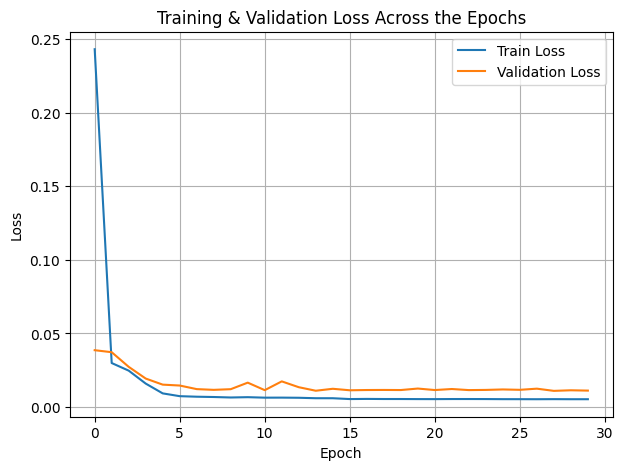

In [ ]:
plt.figure(figsize=(7, 5))
plt.plot(range(len(mlp_train_losses)), mlp_train_losses, label='Train Loss')
plt.plot(range(len(mlp_val_losses)), mlp_val_losses, label='Validation Loss')
plt.title('Training & Validation Loss Across the Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
mlp_mse, mlp_rmse, mlp_mae = evaluate_model(mlp_model, test_dataloader, criterion, device)

Testing Phase Done with the following Evaluation Metrics:
Test Loss: 0.02610968549612102
Mean Square Error (MSE): 0.02610968555853486
Root Mean Square Error (RMSE): 0.16158491748469242
Mean Absolute Error (MAE): 0.14239365302269413


## **RNN**

In [ ]:
class SimpleRNN(nn.Module):

    def __init__(self, input_size, n_neurons):
        super(SimpleRNN, self).__init__()
        self.rnn = nn.RNN(input_size, n_neurons, batch_first=True)
        self.fc = nn.Linear(n_neurons, 1)

    def forward(self, x):
        # x: [batch_size, seq_len, input_size]
        x = x.view(x.size(0), -1, 1)  # [batch_size, seq_len=56, input_size=1]
        #print('1', x.shape)
        out, _ = self.rnn(x)  # out: [batch_size, seq_len, hidden_size]
        #print('2', out.shape)
        out = self.fc(out[:, -1, :])  # take output of last time step
        #print('3', out.shape)
        return out

In [ ]:
rnn_model = SimpleRNN(input_size=1, n_neurons=7)
rnn_train_losses, rnn_val_losses = train_model(rnn_model, train_dataloader, val_dataloader, lr=0.01, n_epochs=30, criterion=criterion, device=device)

Epoch 1/30 Started
Epoch 1/30 - Train Loss: 0.0335, Validation Loss: 0.0324
Epoch 2/30 Started
Epoch 2/30 - Train Loss: 0.0216, Validation Loss: 0.0285
Epoch 3/30 Started
Epoch 3/30 - Train Loss: 0.0161, Validation Loss: 0.0201
Epoch 4/30 Started
Epoch 4/30 - Train Loss: 0.0142, Validation Loss: 0.0219
Epoch 5/30 Started
Epoch 5/30 - Train Loss: 0.0130, Validation Loss: 0.0171
Epoch 6/30 Started
Epoch 6/30 - Train Loss: 0.0092, Validation Loss: 0.0156
Epoch 7/30 Started
Epoch 7/30 - Train Loss: 0.0089, Validation Loss: 0.0128
Epoch 8/30 Started
Epoch 8/30 - Train Loss: 0.0072, Validation Loss: 0.0114
Epoch 9/30 Started
Epoch 9/30 - Train Loss: 0.0074, Validation Loss: 0.0115
Epoch 10/30 Started
Epoch 10/30 - Train Loss: 0.0073, Validation Loss: 0.0205
Epoch 11/30 Started
Epoch 11/30 - Train Loss: 0.0095, Validation Loss: 0.0149
Epoch 12/30 Started
Epoch 12/30 - Train Loss: 0.0085, Validation Loss: 0.0157
Epoch 13/30 Started
Epoch 13/30 - Train Loss: 0.0085, Validation Loss: 0.0151
Epoc

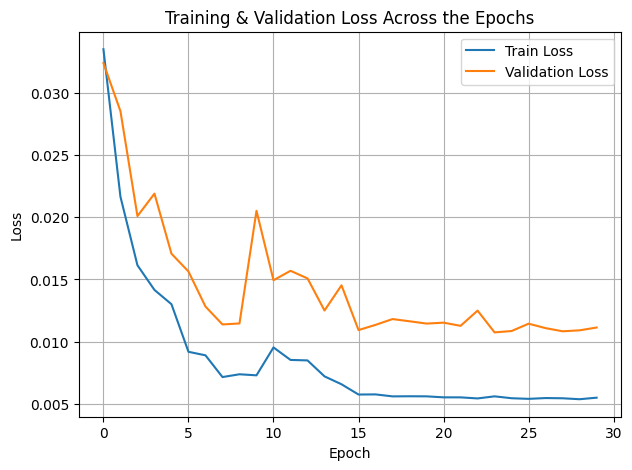

In [ ]:
plt.figure(figsize=(7, 5))
plt.plot(range(len(rnn_train_losses)), rnn_train_losses, label='Train Loss')
plt.plot(range(len(rnn_val_losses)), rnn_val_losses, label='Validation Loss')
plt.title('Training & Validation Loss Across the Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
rnn_mse, rnn_rmse, rnn_mae = evaluate_model(rnn_model, test_dataloader, criterion, device)

Testing Phase Done with the following Evaluation Metrics:
Test Loss: 0.07627538569045789
Mean Square Error (MSE): 0.07627538686352321
Root Mean Square Error (RMSE): 0.2761799899766875
Mean Absolute Error (MAE): 0.23627511478335292


## **GRU**

In [ ]:
class SimpleGRU(nn.Module):

    def __init__(self, input_size, n_neurons):
        super(SimpleGRU, self).__init__()
        self.gru = nn.GRU(input_size=input_size, hidden_size=n_neurons, batch_first=True)
        self.fc = nn.Linear(n_neurons, 1)

    def forward(self, x):
        x = x.view(x.size(0), -1, 1)  # [batch_size, seq_len=56, input_size=1]
        out, _ = self.gru(x)  # [batch_size, seq_len, hidden_size]
        out = self.fc(out[:, -1, :])  # use the last time step
        return out

In [ ]:
gru_model = SimpleGRU(input_size=1, n_neurons=7)
gru_train_losses, gru_val_losses = train_model(gru_model, train_dataloader, val_dataloader, lr=0.01, n_epochs=30, criterion=criterion, device=device)

Epoch 1/30 Started
Epoch 1/30 - Train Loss: 0.0550, Validation Loss: 0.0369
Epoch 2/30 Started
Epoch 2/30 - Train Loss: 0.0309, Validation Loss: 0.0358
Epoch 3/30 Started
Epoch 3/30 - Train Loss: 0.0290, Validation Loss: 0.0358
Epoch 4/30 Started
Epoch 4/30 - Train Loss: 0.0274, Validation Loss: 0.0347
Epoch 5/30 Started
Epoch 5/30 - Train Loss: 0.0260, Validation Loss: 0.0332
Epoch 6/30 Started
Epoch 6/30 - Train Loss: 0.0245, Validation Loss: 0.0289
Epoch 7/30 Started
Epoch 7/30 - Train Loss: 0.0224, Validation Loss: 0.0282
Epoch 8/30 Started
Epoch 8/30 - Train Loss: 0.0204, Validation Loss: 0.0298
Epoch 9/30 Started
Epoch 9/30 - Train Loss: 0.0189, Validation Loss: 0.0240
Epoch 10/30 Started
Epoch 10/30 - Train Loss: 0.0173, Validation Loss: 0.0227
Epoch 11/30 Started
Epoch 11/30 - Train Loss: 0.0154, Validation Loss: 0.0204
Epoch 12/30 Started
Epoch 12/30 - Train Loss: 0.0129, Validation Loss: 0.0172
Epoch 13/30 Started
Epoch 13/30 - Train Loss: 0.0106, Validation Loss: 0.0145
Epoc

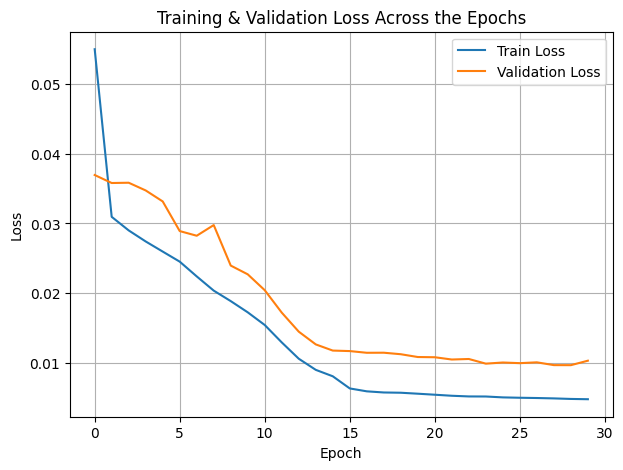

In [ ]:
plt.figure(figsize=(7, 5))
plt.plot(range(len(gru_train_losses)), gru_train_losses, label='Train Loss')
plt.plot(range(len(gru_val_losses)), gru_val_losses, label='Validation Loss')
plt.title('Training & Validation Loss Across the Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
gru_mse, gru_rmse, gru_mae = evaluate_model(gru_model, test_dataloader, criterion, device)

Testing Phase Done with the following Evaluation Metrics:
Test Loss: 0.0758178137885385
Mean Square Error (MSE): 0.07581781392854901
Root Mean Square Error (RMSE): 0.2753503476092758
Mean Absolute Error (MAE): 0.23447220868459254


## **Transformer Encoder**

In [ ]:
class PositionalEncoding(nn.Module):

    def __init__(self, d_model, max_len=56):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, d_model)
        pos = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(pos * div_term)
        pe[:, 1::2] = torch.cos(pos * div_term)
        pe = pe.unsqueeze(0)  # shape: [1, max_len, d_model]
        self.register_buffer('pe', pe)

    def forward(self, x):
        return x + self.pe[:, :x.size(1)]

In [ ]:
class TransformerRegressor(nn.Module):

    def __init__(self, input_dim=1, model_dim=64, n_heads=4, ff_dim=128, num_layers=2):
        super(TransformerRegressor, self).__init__()
        self.input_proj = nn.Linear(input_dim, model_dim)
        self.pos_encoder = PositionalEncoding(d_model=model_dim)

        encoder_layer = nn.TransformerEncoderLayer(d_model=model_dim, nhead=n_heads, dim_feedforward=ff_dim)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        self.regressor = nn.Sequential(
            nn.Linear(model_dim, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )

    def forward(self, x):
        x = x.view(x.size(0), -1, 1)                # [batch_size, seq_len=56, 1]
        x = self.input_proj(x)                      # [batch_size, seq_len, model_dim]
        x = self.pos_encoder(x)                     # add position encoding
        x = x.permute(1, 0, 2)                      # [seq_len, batch_size, model_dim] for Transformer
        x = self.transformer_encoder(x)             # [seq_len, batch_size, model_dim]
        x = x[-1, :, :]                             # use the last time step output: [batch_size, model_dim]
        out = self.regressor(x)                     # [batch_size, 1]
        return out

In [ ]:
transformer_model = TransformerRegressor()
transformer_train_losses, transformer_val_losses = train_model(transformer_model, train_dataloader, val_dataloader, lr=0.01, n_epochs=30, criterion=criterion, device=device)

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch 1/30 Started
Epoch 1/30 - Train Loss: 0.0893, Validation Loss: 0.0503
Epoch 2/30 Started
Epoch 2/30 - Train Loss: 0.0328, Validation Loss: 0.0409
Epoch 3/30 Started
Epoch 3/30 - Train Loss: 0.0334, Validation Loss: 0.0371
Epoch 4/30 Started
Epoch 4/30 - Train Loss: 0.0338, Validation Loss: 0.0391
Epoch 5/30 Started
Epoch 5/30 - Train Loss: 0.0333, Validation Loss: 0.0485
Epoch 6/30 Started
Epoch 6/30 - Train Loss: 0.0329, Validation Loss: 0.0421
Epoch 7/30 Started
Epoch 7/30 - Train Loss: 0.0350, Validation Loss: 0.0390
Epoch 8/30 Started
Epoch 8/30 - Train Loss: 0.0362, Validation Loss: 0.0457
Epoch 9/30 Started
Epoch 9/30 - Train Loss: 0.0336, Validation Loss: 0.0452
Epoch 10/30 Started
Epoch 10/30 - Train Loss: 0.0350, Validation Loss: 0.0376
Epoch 11/30 Started
Epoch 11/30 - Train Loss: 0.0361, Validation Loss: 0.0463
Epoch 12/30 Started
Epoch 12/30 - Train Loss: 0.0344, Validation Loss: 0.0429
Epoch 13/30 Started
Epoch 13/30 - Train Loss: 0.0343, Validation Loss: 0.0387
Epoc

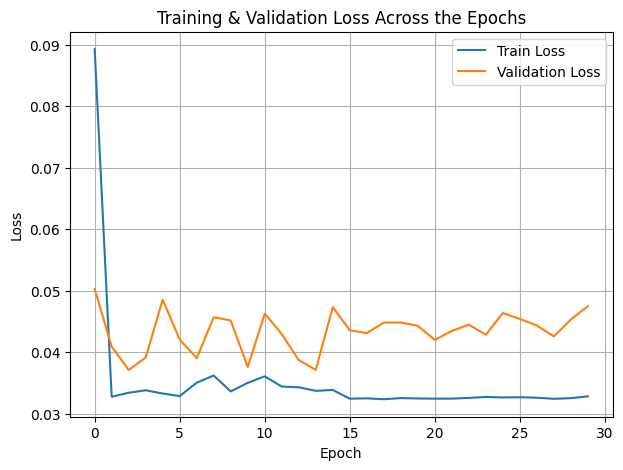

In [ ]:
plt.figure(figsize=(7, 5))
plt.plot(range(len(transformer_train_losses)), transformer_train_losses, label='Train Loss')
plt.plot(range(len(transformer_val_losses)), transformer_val_losses, label='Validation Loss')
plt.title('Training & Validation Loss Across the Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
transformer_mse, transformer_rmse, transformer_mae = evaluate_model(transformer_model, test_dataloader, criterion, device)

Testing Phase Done with the following Evaluation Metrics:
Test Loss: 0.19057746596269673
Mean Square Error (MSE): 0.19057746500400272
Root Mean Square Error (RMSE): 0.43655178960119123
Mean Absolute Error (MAE): 0.3894597922249899


## Hyperparameters and Results

| Model                 | Learning Rate | Epochs | Test Loss | MSE   | RMSE  | MAE   |
|:----------------------|:--------------|:------:|:---------:|:-----:|:-----:|:-----:|
| **MLP**                | 0.001          | 30    | 0.0261    | 0.0261| 0.1616| 0.1424|
| **RNN**                | 0.001          | 30    | 0.0763    | 0.0763| 0.2762| 0.2363|
| **GRU**                | 0.001          | 30    | 0.0758    | 0.0758| 0.2754| 0.2345|
| **Transformer Encoder**| 0.001          | 30    | 0.1906    | 0.1906| 0.4366| 0.3895|





## Experiment, Results, and Analysis

In this experiment, the performance of four different architectures were compared — **MLP**, **RNN**, **GRU**, and **Transformer Encoder** — on a time series regression task.  
The goal was to predict a single scalar value given a sequence of 56 inputs.

All models were trained using the **Adam optimizer** with a **learning rate of 0.001** for **30 epochs**.


### Results Overview:
- **MLP** achieved the best test performance, with the lowest Mean Square Error (MSE) and Mean Absolute Error (MAE).
- **GRU** slightly outperformed **RNN**, showing the benefit of its gating mechanism for handling temporal dependencies.
- **Transformer Encoder** underperformed compared to the others. Although transformers are powerful for sequence modeling, their complexity and the small dataset size (relative to transformer expectations) likely contributed to overfitting and worse generalization.


### Key Observations:
- The **MLP** was surprisingly strong, likely because the sequence was relatively short (56 steps), and simple feed-forward layers were enough to model the data without introducing unnecessary complexity.
- **GRU** improved upon the **RNN** by better managing long-term dependencies, showing slightly better MAE and RMSE.
- The **Transformer Encoder** model did not perform as well, indicating that it might need:
  - More data
  - More careful regularization (e.g., dropout, weight decay)
  - Fewer layers / smaller model size
  - Hyperparameter tuning (e.g., adjusting model dimension, heads, etc.)